In [81]:
import pandas as pd 

In [82]:
df=pd.read_csv("^NSEI.csv")

In [83]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-04-30,10705.750000,10784.650391,10601.599609,10618.250000,10618.250000,775200
1,2018-05-07,10653.150391,10812.049805,10635.650391,10806.500000,10806.500000,1048800
2,2018-05-14,10815.150391,10929.200195,10589.099609,10596.400391,10596.400391,1093900
3,2018-05-21,10616.700195,10628.049805,10417.799805,10605.150391,10605.150391,1091000
4,2018-05-28,10648.349609,10764.750000,10558.450195,10696.200195,10696.200195,1528000
...,...,...,...,...,...,...,...
256,2023-03-27,16984.300781,17381.599609,16913.750000,17359.750000,17359.750000,1067000
257,2023-04-03,17427.949219,17638.699219,17312.750000,17599.150391,17599.150391,721200
258,2023-04-10,17634.900391,17842.150391,17597.949219,17828.000000,17828.000000,1077700
259,2023-04-17,17863.000000,17863.000000,17553.949219,17624.050781,17624.050781,1343100


In [84]:
data=df.reset_index()['Close']

In [85]:
data

0      10618.250000
1      10806.500000
2      10596.400391
3      10605.150391
4      10696.200195
           ...     
256    17359.750000
257    17599.150391
258    17828.000000
259    17624.050781
260    17915.050781
Name: Close, Length: 261, dtype: float64

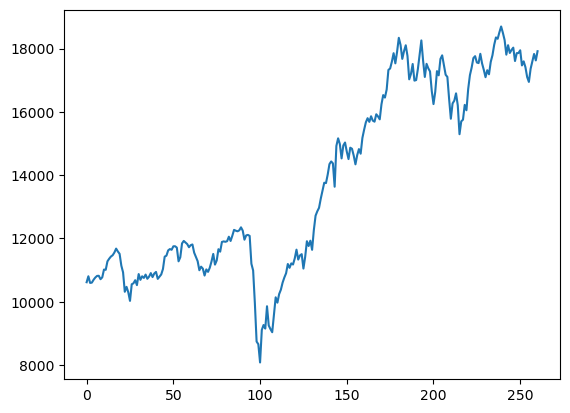

In [86]:
import matplotlib.pyplot as plt
plt.plot(data)

In [87]:
import numpy as np

In [88]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [89]:
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]

In [90]:
test_data

array([[0.72361789],
       [0.76839145],
       [0.79580298],
       [0.78839652],
       [0.8123969 ],
       [0.87066894],
       [0.87497059],
       [0.89531494],
       [0.92057326],
       [0.89031135],
       [0.92453093],
       [0.96630807],
       [0.94523343],
       [0.90346586],
       [0.92656645],
       [0.9440885 ],
       [0.91224345],
       [0.84266837],
       [0.85871108],
       [0.88835607],
       [0.83878137],
       [0.84052942],
       [0.87353836],
       [0.91675693],
       [0.95850573],
       [0.89833031],
       [0.84978276],
       [0.88882722],
       [0.87548885],
       [0.86621196],
       [0.80798703],
       [0.76906514],
       [0.80535318],
       [0.86722493],
       [0.85459329],
       [0.90335267],
       [0.91408554],
       [0.88499673],
       [0.85637888],
       [0.84983945],
       [0.78469798],
       [0.72541774],
       [0.7710252 ],
       [0.77915726],
       [0.8010046 ],
       [0.76496143],
       [0.67937208],
       [0.717

In [91]:
training_size,test_size

(169, 92)

In [92]:
test_size

92

In [93]:
train_data

array([[0.23882196],
       [0.25656081],
       [0.23676306],
       [0.23758758],
       [0.24616722],
       [0.2529    ],
       [0.2576162 ],
       [0.2580072 ],
       [0.24787276],
       [0.25337115],
       [0.27657536],
       [0.27575553],
       [0.30102333],
       [0.30879263],
       [0.31526627],
       [0.31915327],
       [0.32729002],
       [0.33891807],
       [0.33030539],
       [0.32334183],
       [0.28827868],
       [0.26824067],
       [0.21038328],
       [0.22508789],
       [0.20916767],
       [0.18339099],
       [0.23267343],
       [0.23570766],
       [0.244848  ],
       [0.23019989],
       [0.26318048],
       [0.24593165],
       [0.25646188],
       [0.25161372],
       [0.26159274],
       [0.24910244],
       [0.25547246],
       [0.26602626],
       [0.25411551],
       [0.26477301],
       [0.26947974],
       [0.24882454],
       [0.25516152],
       [0.26193193],
       [0.27813015],
       [0.31501652],
       [0.31784822],
       [0.333

In [94]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [95]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 90
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [96]:
y_test

array([0.89898054])

In [97]:
X_test

array([[0.72361789, 0.76839145, 0.79580298, 0.78839652, 0.8123969 ,
        0.87066894, 0.87497059, 0.89531494, 0.92057326, 0.89031135,
        0.92453093, 0.96630807, 0.94523343, 0.90346586, 0.92656645,
        0.9440885 , 0.91224345, 0.84266837, 0.85871108, 0.88835607,
        0.83878137, 0.84052942, 0.87353836, 0.91675693, 0.95850573,
        0.89833031, 0.84978276, 0.88882722, 0.87548885, 0.86621196,
        0.80798703, 0.76906514, 0.80535318, 0.86722493, 0.85459329,
        0.90335267, 0.91408554, 0.88499673, 0.85637888, 0.84983945,
        0.78469798, 0.72541774, 0.7710252 , 0.77915726, 0.8010046 ,
        0.76496143, 0.67937208, 0.71760602, 0.72258136, 0.76673294,
        0.75058192, 0.81373968, 0.855088  , 0.87763259, 0.90596296,
        0.91164494, 0.8928414 , 0.89100851, 0.91870282, 0.89019816,
        0.8710223 , 0.84906665, 0.86982565, 0.85767455, 0.89448104,
        0.91431652, 0.94544545, 0.96735859, 0.96339632, 0.98272291,
        1.        , 0.98120106, 0.95975428, 0.91

In [98]:
print(X_train.shape)  # Check the shape of X_train
print(X_test.shape)   # Check the shape of X_test



(78, 90)
(1, 90)


In [99]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] ,1)

In [100]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [105]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(90,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [106]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 90, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 90, 50)            20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 90, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 90, 50)            20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [108]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=90,batch_size=64,verbose=1)

Epoch 1/90
2/2 [==============================] - 10s 2s/step - loss: 0.1922 - val_loss: 0.3034
Epoch 2/90
2/2 [==============================] - 0s 130ms/step - loss: 0.0863 - val_loss: 0.0093
Epoch 3/90
2/2 [==============================] - 0s 133ms/step - loss: 0.0270 - val_loss: 0.0733
Epoch 4/90
2/2 [==============================] - 0s 132ms/step - loss: 0.0429 - val_loss: 0.0149
Epoch 5/90
2/2 [==============================] - 0s 132ms/step - loss: 0.0239 - val_loss: 0.0072
Epoch 6/90
2/2 [==============================] - 0s 129ms/step - loss: 0.0187 - val_loss: 0.0442
Epoch 7/90
2/2 [==============================] - 0s 132ms/step - loss: 0.0263 - val_loss: 0.0617
Epoch 8/90
2/2 [==============================] - 0s 132ms/step - loss: 0.0287 - val_loss: 0.0481
Epoch 9/90
2/2 [==============================] - 0s 131ms/step - loss: 0.0250 - val_loss: 0.0244
Epoch 10/90
2/2 [==============================] - 0s 152ms/step - loss: 0.0193 - val_loss: 0.0053
Epoch 11/90
2/2 [====

In [109]:
import tensorflow as tf

In [110]:
tf.__version__


'2.13.0'

In [111]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



1/1 [==============================] - 0s 48ms/step


In [112]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [114]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

12461.646070276141

In [116]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

17387.290472588058

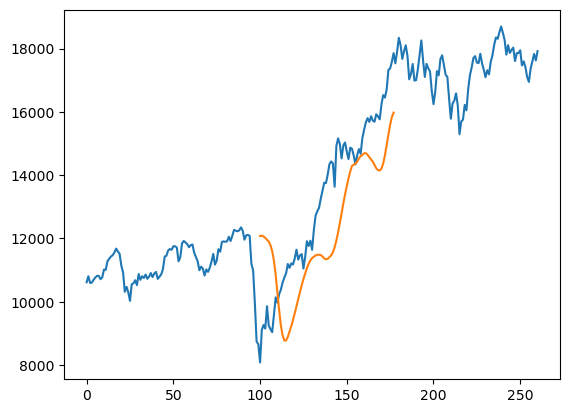

In [117]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [123]:
import pickle

# Assuming X_train and X_test are your data arrays

# Reshape the data (as shown in your previous code)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create a dictionary to hold the data
data = {
    'X_train': X_train_reshaped,
    'X_test': X_test_reshaped
}

# Specify the path and filename for the pickle file
filename = 'data.pickle'

# Pickle the data and save it to the file
with open(filename, 'wb') as f:
    pickle.dump(data, f)

print(f"Data saved to {filename}.")


Data saved to data.pickle.
